In [121]:
import os
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import plotly.express as px


In [122]:
df = pd.read_excel('/content/drive/MyDrive/ColabNotebooks/GoalEarn/Prj-8/GitHub/online_retail_cleaningdata.xlsx')

In [174]:
df.head()

,Unnamed: 0,invoice_id,item_id,description,quantity,date,unit_price,sales,customer_id,country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,15.30,17850,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,20.34,17850,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,22.00,17850,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,20.34,17850,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,20.34,17850,United Kingdom


In [124]:
df.isnull().sum()

,0
Unnamed: 0,0
invoice_id,0
item_id,0
description,0
quantity,0
date,0
unit_price,0
sales,0
customer_id,0
country,0


# Finding RFM values

## Recency

In [125]:
day = '2011-12-10'
day = pd.to_datetime(day)
day

Timestamp('2011-12-10 00:00:00')

In [126]:
df['date'].max() , df['date'].min()

(Timestamp('2011-12-09 12:50:00'), Timestamp('2010-12-01 08:26:00'))

In [144]:
recency = df.groupby(['customer_id']).agg({"date": lambda x:((day-x.max()).days)}).reset_index()
recency = recency.rename(columns={'date': 'recency'})
recency

,customer_id,date
0,12347,2
1,12348,75
2,12349,18
3,12350,310
4,12352,36
...,...,...
4285,18280,277
4286,18281,180
4287,18282,7
4288,18283,3


In [146]:
df.customer_id.unique().shape

(4290,)

## Ferequency (In Two Ways)

In [147]:
frequency_1 = df.drop_duplicates(subset ='invoice_id').groupby(['customer_id'])[['invoice_id']].count()
frequency_1

In [149]:
frequency = df.groupby(['customer_id']).invoice_id.nunique().reset_index()
frequency = frequency.rename(columns={'invoice_id' : 'frequency'})
frequency.head()

,customer_id,invoice_id
0,12347,7
1,12348,4
2,12349,1
3,12350,1
4,12352,7


## Monetary

In [151]:
monetary = df.groupby(['customer_id'])[['sales']].sum().reset_index()
monetary = monetary.rename(columns={'sales' : 'monetary'})
monetary.head()

,customer_id,sales
0,12347,4060.40
1,12348,1186.68
2,12349,1353.80
3,12350,294.40
4,12352,1385.74


## RFM Values

In [154]:
rfm_values = recency.merge(frequency, on='customer_id')
rfm_values = rfm_values.merge(monetary, on='customer_id')

rfm_values.head()


,customer_id,recency,frequency,monetary
0,12347,2,7,4060.40
1,12348,75,4,1186.68
2,12349,18,1,1353.80
3,12350,310,1,294.40
4,12352,36,7,1385.74


In [155]:
rfm_values.isnull().sum()

,0
customer_id,0
recency,0
frequency,0
monetary,0


In [160]:
rfm_sorted = rfm_values.sort_values('monetary' , ascending=False)
rfm_sorted.head()

,customer_id,recency,frequency,monetary
1676,14646,2,64,158967.80
1866,14911,1,198,125132.11
3736,17511,2,30,73056.39
1323,14156,9,51,70571.29
54,12415,24,15,67004.37


**CLV Historical**

In [161]:
df.head()

,Unnamed: 0,invoice_id,item_id,description,quantity,date,unit_price,sales,customer_id,country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,15.30,17850,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,20.34,17850,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,22.00,17850,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,20.34,17850,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,20.34,17850,United Kingdom


In [162]:
clv_historical = df.groupby('customer_id')['sales'].sum().reset_index()
clv_historical.columns = ['customer_id', 'clv_historical']
clv_historical.sort_values(by = 'clv_historical' , ascending = False)

,customer_id,clv_historical
1676,14646,158967.80
1866,14911,125132.11
3736,17511,73056.39
1323,14156,70571.29
54,12415,67004.37
...,...,...
2989,16454,6.90
1780,14792,6.20
2971,16429,4.95
3189,16738,3.75


In [163]:
rfm_clv = rfm_values.merge(clv_historical , on = 'customer_id' , how = 'left')
rfm_clv.head()

,customer_id,recency,frequency,monetary,clv_historical
0,12347,2,7,4060.40,4060.40
1,12348,75,4,1186.68,1186.68
2,12349,18,1,1353.80,1353.80
3,12350,310,1,294.40,294.40
4,12352,36,7,1385.74,1385.74


In [164]:
relevant_cols = ["recency", "frequency", "monetary" , "clv_historical"]
rfm_clv_n = rfm_clv[relevant_cols]

In [165]:
rfm_clv_n.head()

,recency,frequency,monetary,clv_historical
0,2,7,4060.40,4060.40
1,75,4,1186.68,1186.68
2,18,1,1353.80,1353.80
3,310,1,294.40,294.40
4,36,7,1385.74,1385.74


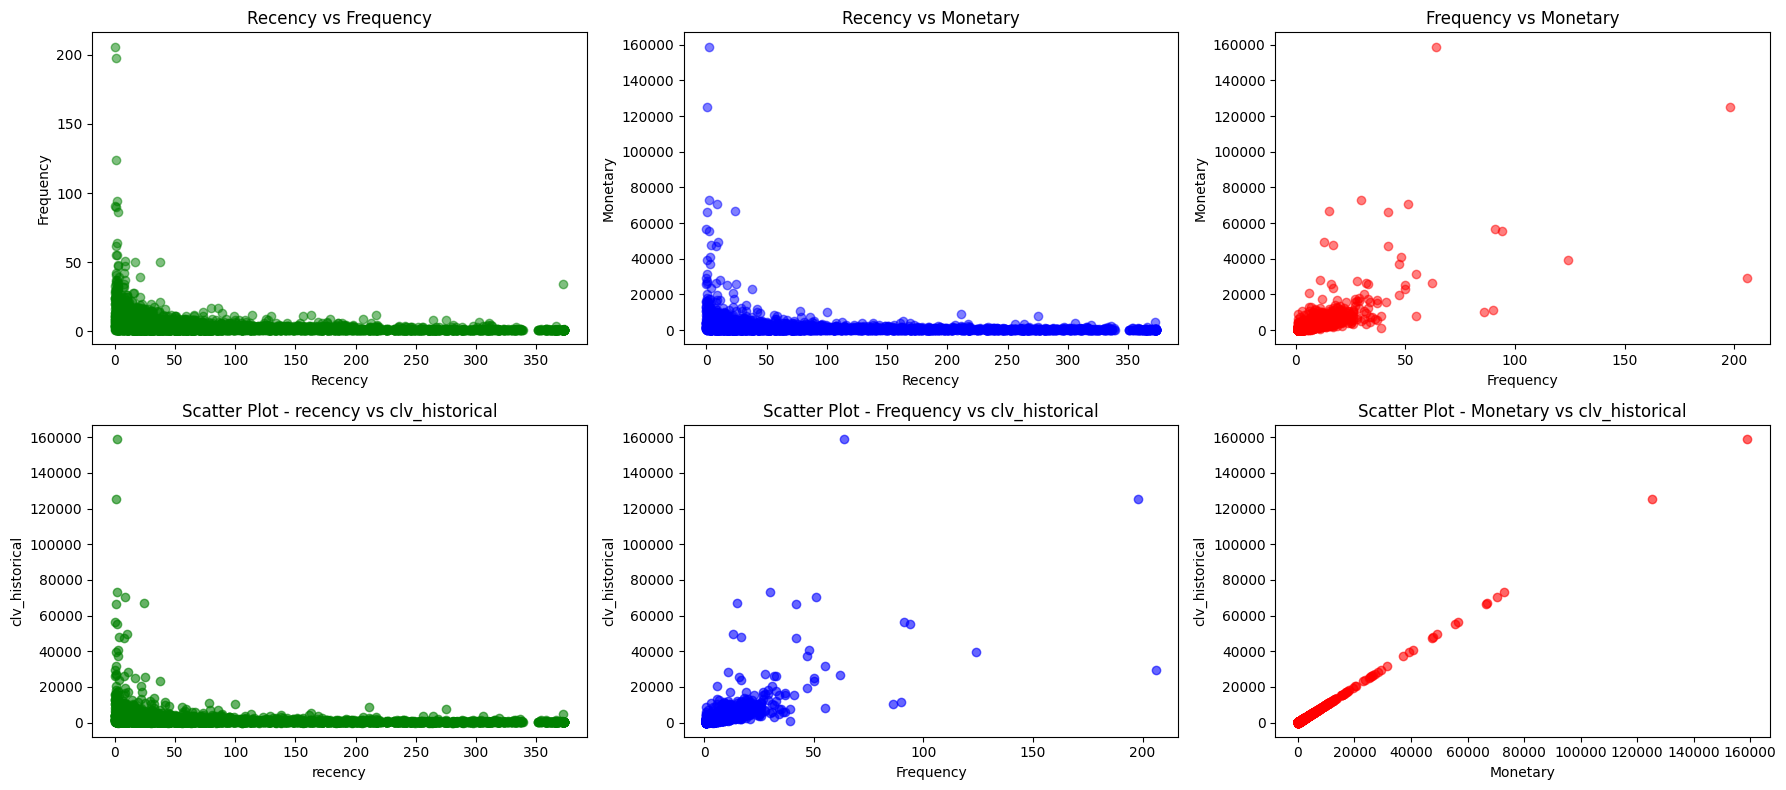

In [166]:
plt.figure(figsize=(18,8))

# Recency vs Frequency
plt.subplot(2, 3, 1)
plt.scatter(rfm_clv_n['recency'], rfm_clv_n['frequency'], color='green', alpha=0.5)
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Recency vs Frequency')

# Recency vs Monetary
plt.subplot(2, 3, 2)
plt.scatter(rfm_clv_n['recency'], rfm_clv_n['monetary'], color='blue', alpha=0.5)
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.title('Recency vs Monetary')

# Frequency vs Monetary
plt.subplot(2, 3, 3)
plt.scatter(rfm_clv_n['frequency'], rfm_clv_n['monetary'], color='red', alpha=0.5)
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Frequency vs Monetary')

# recency vs clv_historical
plt.subplot(2, 3, 4)
plt.scatter(rfm_clv_n['recency'], rfm_clv_n['clv_historical'], color='green', alpha=0.6)
plt.xlabel('recency')
plt.ylabel('clv_historical')
plt.title('Scatter Plot - recency vs clv_historical')

# Frequency vs clv_historical
plt.subplot(2, 3, 5)
plt.scatter(rfm_clv_n['frequency'], rfm_clv_n['clv_historical'], color='blue', alpha=0.6)
plt.xlabel('Frequency')
plt.ylabel('clv_historical')
plt.title('Scatter Plot - Frequency vs clv_historical')

# Frequency vs clv_historical
plt.subplot(2, 3, 6)
plt.scatter(rfm_clv_n['monetary'], rfm_clv_n['clv_historical'], color='red', alpha=0.6)
plt.xlabel('Monetary')
plt.ylabel('clv_historical')
plt.title('Scatter Plot - Monetary vs clv_historical')


plt.tight_layout()
plt.show()


In [167]:
rfm_clv.to_csv('/content/drive/MyDrive/ColabNotebooks/GoalEarn/Prj-8/GitHub/online_retail_rfm_clv(historical)_realdata.csv')

In [169]:
rfm_clv.to_excel('/content/drive/MyDrive/ColabNotebooks/GoalEarn/Prj-8/GitHub/online_retail_rfm_clv(historical)_realdata.xlsx')

In [171]:
rfm_clv_n

,recency,frequency,monetary,clv_historical
0,2,7,4060.40,4060.40
1,75,4,1186.68,1186.68
2,18,1,1353.80,1353.80
3,310,1,294.40,294.40
4,36,7,1385.74,1385.74
...,...,...,...,...
4285,277,1,180.60,180.60
4286,180,1,46.92,46.92
4287,7,2,178.05,178.05
4288,3,16,2078.93,2078.93
